# UAS_processing
Creators: Seth Ackerman (@sackerman-usgs), Emily Sturdivant (@esturdivant-usgs)

Jupyter notebook to process image and GPX files.

## Pre-reqs:

1. Convert the tlog file to gpx. We use Mission Planner with the computer time zone set to UTC.

## Detailed workflow:

1. **Read the GPX file.** View a dataframe from the GPX file.
2. **Parse the time** field in the GPX dataframe. Add fields datetime_utc and epoch_utc.
3. Export the dataframe as a table in CSV format and map the flight path from the GPX navigation data.
4. Plot the flight path on an aerial photo basemap.
5. Initialize a dataframe for the images. Include the original filename and the time in UTC, Epoch, and ISO formats.
6. Export a CSV of the dataframe. Plot the image times and the GPX elevations by time to check that they match.
8. **Geotag the photos** from the GPX file using the Geosync tool in ExifTool.
7. **Rename the photos** using the survey number, the flight and camera ID, the time in ISO format, and the original filename.
9. **Update EXIF tags** to standard values.

## Requirements
Python 3 with modules (in addition to defaults):

- lxml
- Pillow, a fork of PIL for Image processing
- pandas
- numpy
- matplotlib
- ipyleaflet

We recommend creating the uas-processing conda environment from the YML file in this repo.

```
conda env create -f uas-processing.yml
```

### To use ipyleaflet

Try this:
```
conda install -c conda-forge ipyleaflet
```
If that doesn't work:

```
pip install ipyleaflet
jupyter nbextension enable --py --sys-prefix ipyleaflet
```
If that fails on the second line: (If it fails on the first line you're screwed.)
```
conda update numpy
jupyter nbextension enable --py --sys-prefix ipyleaflet
```
If that doesn't work, find a solution and fix it for us!

#### If using jupyter lab

```
jupyter labextension install @jupyter-widgets/jupyterlab-manager
```
and follow directions to install dependencies (nodejs, npm)

## Inputs/outputs

Variables:

- homedir: working directory that contains image folder and tlog folder (with gpx file) and where outputs will be saved.
- flight: flight ID that matches the image folder name and the gpx file, usually in format fX
- logfile: gpx file path
- imagefolder: image folder path

Output products:

- CSV of pertinent telemetry data converted from GPX
- PNG of flight path created from GPX
- new folder of images with standardized filenames and image headers populated with contextual information

Look for options to customize the geotag portion.


### Import packages and define the namespace for the GPX schema

If you get an error here, you will have to add packages to your Python distribution

In [4]:
import os, string, copy, sys, subprocess
import shutil
import datetime as datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from lxml import etree
from PIL import Image, ExifTags
import ipyleaflet as ipyl

# set pandas output to limit to N records
pd.set_option('max_rows', 8)

%matplotlib inline

## Input Variables 

In [5]:
# Set local filepaths:
homedir = r'X:/AIM_projects/2019_009_FA_PlumIsland_March/' # '/Data/2018_PlumIsland/2018_015_FA_PlumIs_Feb/test_script/ricoh'
#logfile = r'/Data/AIM_2019_PlumIsland/RAW/telemetry/GPX_for_geotagging/f11.gpx'
#imagefolder = r'/Data/AIM_2019_PlumIsland/RAW/photos/ricoh_JPG/ricoh_f11'
logfile = r'X:/AIM_projects/2019_009_FA_PlumIsland_March/telemetry/GPX_for_geotagging/f11.gpx'
imagefolder = r'X:/AIM_projects/2019_009_FA_PlumIsland_March/photos/ricoh_JPG/ricoh_f11'

# Mission info - would be nice for logfile and image folder names to correspond to naming convention, as below
fan = '2019-009-FA' # input('Field activity number (e.g. "2017-010-FA"): ')
flight_id = 'f11' 
cam_id = 'r01' 
location = 'Plum Island'
state = 'Massachusetts'

# Geotag value: 
# - If images and GPX file were created in UTC, use -0:0:0. If images are local time use +4:0:0 for EST or +5:0:0 for EDT
geosync = '+4:0:0'

### Defaults that you shouldn't need to change if you are publishing as the WHSC AIM Group

In [6]:
# Automated file/folder names
navcsvoutfile = os.path.splitext(logfile)[0]+'_gpx.csv'
imgoutdir = imagefolder+'_new'

# WHSC EXIF population
credit = "U.S. Geological Survey"
comment = """Low-altitude aerial photograph of {0}, {1} from 
survey {2} (https://cmgds.marine.usgs.gov/fan_info.php?fa={2}).""".format(location, state, fan)
keywords = "{}, {}, {}, UAS, nadir, USGS".format(location, state, fan)
artist = "WHCMSC AIM Group"
contact = "WHSC_data_contact@usgs.gov"

### Verify the user input data looks right before continuing

In [7]:
if not os.path.isdir(homedir):
    print("We don't see the specified directory (homedir variable): {}".format(homedir))
    sys.exit()
elif not os.path.isfile(logfile):
    print("We don't see the specified file (logfile variable): {}".format(logfile))
    sys.exit()
elif not os.path.isdir(imagefolder):
    print("We don't see the specified directory (imagefolder variable): {}".format(imagefolder))
    sys.exit()
else:
    print("Your input files and folders are all present. Well done! Carry on.")

input_check = "\nFA = {}    \nflight = {}    \nsensor = {}".format(fan, flight_id, cam_id)
print ("\nInput data: "+ input_check)

print('Does the input data above look right?')

Your input files and folders are all present. Well done! Carry on.

Input data: 
FA = 2019-009-FA    
flight = f11    
sensor = r01
Does the input data above look right?


## Parse GPX file and extract components into dataframe

In [8]:
def gpx_tag_to_pdseries(tree, namespace, tag):
    """
    # Extract tag value from GPX file as pandas series
    First, get the element list.
    """
    elist = tree.xpath('./def:trk//def:trkpt//def:'+tag, namespaces=namespace)
    ser = pd.Series([e.text for e in elist], name=tag)
    return(ser)

# Parse GPX
tree = etree.parse(logfile)

# Extract latitude and longitude to initialize GPX dataframe
namespace = {'def': 'http://www.topografix.com/GPX/1/1'}
elist = tree.xpath('./def:trk//def:trkpt',namespaces=namespace)
gpxdf = pd.DataFrame([e.values() for e in elist], columns=['lat', 'lon']).apply(pd.to_numeric)

# Extract each tag (including time) and add to dataframe
taglist = ['time', 'ele', 'ele2', 'course', 'roll', 'pitch', 'mode']
for tag in taglist:
    gpxdf = gpxdf.join(pd.to_numeric(gpx_tag_to_pdseries(tree, namespace, tag), errors='ignore'))

# Check number of records and number of unique times 
print ("Number of records in GPX file: ", len(gpxdf.index))
print ("Number of unique time stamps in GPX file: {}\n".format(len(gpxdf.time.unique())))

gpxdf.describe()
gpxdf

Number of records in GPX file:  5729
Number of unique time stamps in GPX file: 714



,lat,lon,time,ele,ele2,course,roll,pitch,mode
0,42.772479,-70.805902,2019-03-28T20:57:15+00:00,1.45,0.03,275.1313,-1.391226,1.048569,Loiter
1,42.772479,-70.805902,2019-03-28T20:57:15+00:00,1.71,0.29,275.1572,-1.385055,1.042983,Loiter
2,42.772479,-70.805902,2019-03-28T20:57:16+00:00,1.92,0.50,275.1731,-1.386346,1.053080,Loiter
3,42.772479,-70.805902,2019-03-28T20:57:16+00:00,2.75,1.33,275.2366,-1.382809,1.028998,Loiter
...,...,...,...,...,...,...,...,...,...
5725,42.772491,-70.805901,2019-03-28T21:09:14+00:00,4.19,1.83,255.2332,-1.521043,0.797509,Loiter
5726,42.772491,-70.805901,2019-03-28T21:09:14+00:00,4.14,1.78,255.2647,-1.509549,0.796148,Loiter
5727,42.772490,-70.805901,2019-03-28T21:09:14+00:00,4.08,1.72,255.2983,-1.489238,0.799458,Loiter
5728,42.772490,-70.805901,2019-03-28T21:09:15+00:00,4.02,1.66,255.3280,-1.487878,0.810058,Loiter


### Add datetime field to gpxdf dataframe and export CSV

Convert the time field to: 

- datetime_utc: datetime in UTC
- epoch_utc: Unix epoch time, which counts seconds from January 1, 1970

In [9]:
# Convert values in 'time' field to datetime UTC and convert datetime UTC to Epoch UTC
tfmt_gpx = '%Y-%m-%dT%H:%M:%S' #e.g. 2017-05-04T14:14:12-04:00
gpxdf['datetime_utc'] = pd.to_datetime(gpxdf['time'], format = tfmt_gpx)
gpxdf['epoch_utc'] = gpxdf['datetime_utc'].astype(np.int64) // 10**9

# Export CSV
gpxdf.to_csv(navcsvoutfile, index=False)
print ("Exported output CSV file to:", navcsvoutfile,"\n")

Exported output CSV file to: X:/AIM_projects/2019_009_FA_PlumIsland_March/telemetry/GPX_for_geotagging/f11_gpx.csv 



### Plot GPX on basemap

In [74]:
def df_to_linestring(df, lat='lat', lon='lon', z='ele'):
    """
    Turn a dataframe containing point data into a linestring in geojson format
    modified from: https://github.com/gboeing/urban-data-science/blob/3faf7e028d48cb03ddb999c5a910213c5384e7dc/17-Leaflet-Web-Mapping/leaflet-simple-demo/pandas-to-geojson.ipynb
    
    df : the dataframe to convert to geojson
    lat : the name of the column in the dataframe that contains latitude data
    lon : the name of the column in the dataframe that contains longitude data
    """
    # create a new python dict to contain our geojson data, using geojson format
    geojson = {'type':'FeatureCollection', 'features':[]}
    
    # create a feature template to fill in
    feature = {'type':'Feature',
               'properties':{},
               'geometry':{'type':'LineString',
                           'coordinates':[]}}
    
    # loop through each row in the dataframe and convert each row to geojson format
    for _, row in df.iterrows():
        # fill in the coordinates
        feature['geometry']['coordinates'].append([row[lon],row[lat],row[z]])

    # add this feature (aka, converted dataframe row) to the list of features inside our dict
    geojson['features'].append(feature)
    
    return(geojson)

#TODO: figure out a way to cache the map layer or load a geotiff so we can do this offline
m = ipyl.Map(
    center=[np.mean([max(gpxdf.lat), min(gpxdf.lat)]), np.mean([max(gpxdf.lon), min(gpxdf.lon)])], 
    zoom=16, 
    layout=dict(width='600px', height='400px'),
    basemap=ipyl.basemaps.Esri.WorldImagery)

def handle_draw(self, action, geo_json):
    print(action)
    print(geo_json)
    
dc = ipyl.DrawControl()
dc.on_draw(handle_draw)
m.add_control(dc)

# Plotting the points (even only the unique times) is unwieldy. Plotting all points crashed my kernel. Plotting the unique ones worked, but there's  no apparent way to customize the point display. 
flight_path = df_to_linestring(gpxdf)
m.add_layer(ipyl.GeoJSON(data=flight_path))
m



ModuleNotFoundError: No module named 'folium'

## Work on the photos

Quirks from ExifTool that required work-arounds: 

- ExifTool assumes that both the GPS and the image times are local unless another timezone is specified (unless taken from GPSTimeStamp which is UTC).

We normally set our camera to UTC and save the GPX files in UTC (by setting the computer time to UTC before running the Mission Planner conversion). Thus, running -geotag on a computer in local time without the '-geotime<${{DateTimeOriginal}}+00:00' part causes the camera times to be incorreclty adjusted to UTC. Our work-around uses the command to geotag images for which the camera clock was set to UTC (+00:00), using the time from DateTimeOriginal. It would also work to change the geosync value to account for this. 

This process uses PIL through Pillow, a fork that updates to PIL to Python 3, but an alternative would be to use a one line call to exiftool. 

### Geotag

In [56]:
# Run the ExifTool command to geotag images with a GPX file
if not os.path.exists(imgoutdir):
    shutil.copytree(imagefolder, imgoutdir)
    print("Created folder {} with images from {}. It did not already exist.".format(imgoutdir, imagefolder))
    
# Geotag images for which the camera clock was set to UTC (+00:00), using the time from DateTimeOriginal: (from ExifTool docs)

## Hey Emily - this command didn't work for me but if i remove the stuff around DateTimeOriginal it works
#cmd = """exiftool -v2 -geotag {} -geosync={} "-geotime<${{DateTimeOriginal}}+00:00" {} -overwrite_original""".format(logfile, 
#                                                                                                 geosync, imgoutdir) 
# for Windows, I needed to hardcode the path to exiftool - sda July2020
cmd = """C:\Program Files\exiftool-12.01\exiftool.exe -v2 -geotag {} -geosync={} "-geotime<DateTimeOriginal" {} -overwrite_original""".format(logfile, 
                                                                                                 geosync, imgoutdir) 
#subprocess.check_call(cmd, shell=True) #not working on Windows
subprocess.check_call(cmd) #this works, had to remove the 'shell=True' - sda 16July2020 

print("Looks like your photos have been geotagged!")
#TODO: enable customization 

Created folder X:/AIM_projects/2019_009_FA_PlumIsland_March/photos/ricoh_JPG/ricoh_f11_new with images from X:/AIM_projects/2019_009_FA_PlumIsland_March/photos/ricoh_JPG/ricoh_f11. It did not already exist.
Looks like your photos have been geotagged!


### Get image times 

In [59]:
# List all JPEGS in imagefolder
flist=[os.path.join(imgoutdir, f) for f in os.listdir(imgoutdir) if f.lower().endswith('.jpg')]
print("Found {} images in {}.".format(len(flist), imgoutdir))

# Set datetime formats
iso_fmt="%Y%m%dT%H%M%SZ"
tfmt_exif = '%Y:%m:%d %H:%M:%S' #e.g. 2017:05:04 14:14:12

def get_datetime(f):
    timestr = list(str(int(x/y)) for x, y in Image.open(f)._getexif()[34853][7])
    datestr = Image.open(f)._getexif()[34853][29]
    datetimestr = '{} {}'.format(datestr, ':'.join(timestr))
    return(datetimestr)

dt = [datetime.datetime.strptime(get_datetime(f), tfmt_exif) for f in flist]

# Make dataframe from photo exif values
imgdf = pd.DataFrame({'orig_name': [os.path.basename(f) for f in flist],
                      'time_utc': dt,
                      'time_epoch': pd.to_datetime(dt, format = tfmt_exif).astype(np.int64) // 10**9, 
                      'time_iso': [t.strftime(iso_fmt) for t in dt],
                      'new_name': np.nan},
                        columns=['new_name', 'time_utc', 'orig_name', 'time_epoch', 'time_iso'])

## Hey Emily - for some reason the file list is coming in out of order, so these 1st and last images are meaningless
# print first and last image name and times
print("First file: {}, time: {}".format(imgdf.orig_name.iloc[0],imgdf.time_utc.iloc[0]))
print("Last file: {}, time: {}".format(imgdf.orig_name.iloc[-1],imgdf.time_utc.iloc[-1]),"\n")
# print first and last times in .gpx file
print("GPX data: {} from {} to {}".format(logfile, gpxdf.datetime_utc.iloc[0],gpxdf.datetime_utc.iloc[-1]))

Found 39 images in X:/AIM_projects/2019_009_FA_PlumIsland_March/photos/ricoh_JPG/ricoh_f11_new.
First file: P0051289.JPG, time: 2019-03-28 21:00:36
Last file: P0051290.JPG, time: 2019-03-28 21:00:38 

GPX data: X:/AIM_projects/2019_009_FA_PlumIsland_March/telemetry/GPX_for_geotagging/f11.gpx from 2019-03-28 20:57:15+00:00 to 2019-03-28 21:09:15+00:00


In [28]:
# Double check that the imgdf dataframe was created correctly

,new_name,lat,lon,ele,time_utc,orig_name,time_epoch,time_iso,interpolated
0,NaN,NaN,NaN,NaN,2019-03-28 17:00:36,P0051289.JPG,1553792436,20190328T170036Z,0
1,NaN,NaN,NaN,NaN,2019-03-28 17:00:10,P0051276.JPG,1553792410,20190328T170010Z,0
2,NaN,NaN,NaN,NaN,2019-03-28 17:01:02,P0051302.JPG,1553792462,20190328T170102Z,0
3,NaN,NaN,NaN,NaN,2019-03-28 17:01:04,P0051303.JPG,1553792464,20190328T170104Z,0
...,...,...,...,...,...,...,...,...,...
35,NaN,NaN,NaN,NaN,2019-03-28 17:00:40,P0051291.JPG,1553792440,20190328T170040Z,0
36,NaN,NaN,NaN,NaN,2019-03-28 17:00:28,P0051285.JPG,1553792428,20190328T170028Z,0
37,NaN,NaN,NaN,NaN,2019-03-28 17:00:26,P0051284.JPG,1553792426,20190328T170026Z,0
38,NaN,NaN,NaN,NaN,2019-03-28 17:00:38,P0051290.JPG,1553792438,20190328T170038Z,0


### Plot

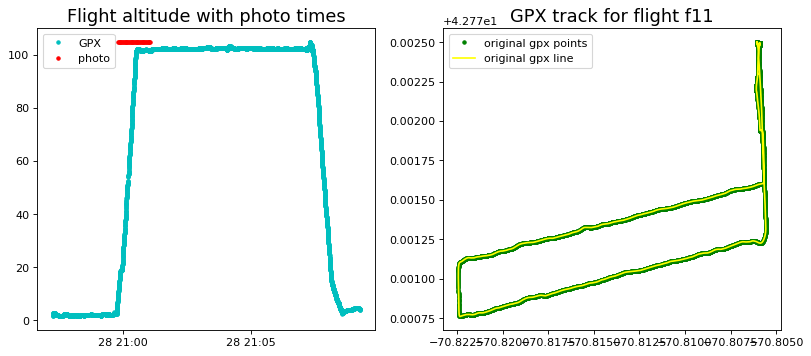

In [60]:
#%% Plot times of image vs GPX data
fig = plt.figure(figsize=(12, 5), dpi= 80, facecolor='w', edgecolor='k')

# Altitudes with photo times
ax = plt.subplot(1,2,1)
ax.plot(gpxdf.datetime_utc, gpxdf.ele,'.c', label='GPX')
ax.plot(imgdf.time_utc, np.tile(gpxdf.ele.max(), imgdf.shape[0]),'.r', label='photo')
ax.legend()
ax.set_title('Flight altitude with photo times', fontsize=16)

# GPX track
ax = plt.subplot(1,2,2)
ax.plot(gpxdf.lon, gpxdf.lat,'.', c='green', label="original gpx points")
ax.plot(gpxdf.lon, gpxdf.lat,'-', c='yellow', label="original gpx line")
ax.legend()
ax.set_title('GPX track for flight {}'.format(flight_id), fontsize=16)

# Display
plt.show()

# Save the figure as a PNG file
fig.savefig(os.path.join(homedir, "{}_gpxtrack.png".format(os.path.splitext(logfile)[0])))
fig.clear()

### Rename files

In [61]:
#TODO: don't run if the names have already been changed...
rename_photos = True

surveyid = fan.replace("-","")
for idx, row in imgdf.iterrows():
    img = row.orig_name
    namestr = "{}_{}{}_{}_{}".format(surveyid, flight_id, cam_id, row.time_iso, img)
    if rename_photos:
        os.rename(os.path.join(imgoutdir, img), os.path.join(imgoutdir, namestr))
    imgdf.loc[idx, 'new_name'] = namestr

print ("Photos were renamed and can be found in:", imgoutdir,"\n")

# Export CSV for original photo EXIF times
imgcsvoutfile = imagefolder+'_imgtmp.csv'
imgdf.to_csv(imgcsvoutfile, index=False)
print ("Exported photo CSV file as:", imgcsvoutfile,"\n")

Photos were renamed and can be found in: X:/AIM_projects/2019_009_FA_PlumIsland_March/photos/ricoh_JPG/ricoh_f11_new 

Exported photo CSV file as: X:/AIM_projects/2019_009_FA_PlumIsland_March/photos/ricoh_JPG/ricoh_f11_imgtmp.csv 



### Add standard USGS metadata to EXIF headers
I needed to hard code the location of exiftools - this might be different depending on ExifTools install. If needed, you can always run it at the command line flight-by-flight


In [65]:
def write_WHSC_exiftags(imgdir, credit, comment, keywords, artist, contact):
    # Tags that will be identical for all images in the folder
    tagvalues = {}
    tagvalues['imgdir'] = imgdir
    tagvalues['credit'] = credit
    tagvalues['artist'] = artist
    tagvalues['contact'] = contact
    tagvalues['comment'] = comment
    tagvalues['keywords'] = keywords
    tagvalues['copyright'] = "Public Domain. Please credit {credit}".format(**tagvalues)
    # Write to EXIF # for Windows, I needed to hardcode the path to exiftool - sda July2020
    cmd = """C:\Program Files\exiftool-12.01\exiftool.exe -Artist="{artist} " -Credit="{credit} " -Contact="{contact} " -comment="{comment} " -sep ", " -keywords="{keywords} " -Caption="{comment} " -Copyright="{copyright} " -CopyrightNotice="{copyright} " -Caption-Abstract="{comment} " -ImageDescription="{comment} " {imgdir}""".format(**tagvalues)
    #subprocess.check_call(cmd, shell=True)
    subprocess.check_call(cmd) # removed the 'shell=True' for Windows - sda July2020
    print("Updated Exif headers in directory: {}".format(imgdir))
    return(True)

# Run ExifTool again to update other USGS specific meta tags
write_WHSC_exiftags(imgoutdir, credit, comment, keywords, artist, contact)

Updated Exif headers in directory: X:/AIM_projects/2019_009_FA_PlumIsland_March/photos/ricoh_JPG/ricoh_f11_new


True